In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
vancouver = pd.read_csv("crime.csv")

In [3]:
vancouver.drop(['MINUTE'], axis=1, inplace=True)
vancouver['NEIGHBOURHOOD'].fillna('N/A', inplace=True)

In [4]:
vancouver['DATE'] = pd.to_datetime({'year':vancouver['YEAR'], 'month':vancouver['MONTH'], 'day':vancouver['DAY']})
vancouver['Day of Week'] = vancouver['DATE'].dt.dayofweek

In [5]:
vancouver.index = pd.DatetimeIndex(vancouver['DATE'])

In [6]:
vancouver = vancouver[vancouver['DATE'] < '2017-01-01']

In [7]:
def category(crime_type):
    if 'Theft' in crime_type:
        return 'Theft'
    elif 'Break' in crime_type:
        return 'Break and Enter'
    elif 'Collision' in crime_type:
        return 'Vehicle Collision'
    else:
        return 'Others'
    
vancouver['CATEGORY'] = vancouver['TYPE'].apply(category)

In [8]:
vancouver.head()

,TYPE,YEAR,MONTH,DAY,HOUR,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,Latitude,Longitude,DATE,Day of Week,CATEGORY
DATE,,,,,,,,,,,,,,
2003-05-12,Other Theft,2003,5,12,16.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763,2003-05-12,0,Theft
2003-05-07,Other Theft,2003,5,7,15.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763,2003-05-07,2,Theft
2003-04-23,Other Theft,2003,4,23,16.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763,2003-04-23,2,Theft
2003-04-20,Other Theft,2003,4,20,11.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763,2003-04-20,6,Theft
2003-04-12,Other Theft,2003,4,12,17.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763,2003-04-12,5,Theft


In [9]:
vancouver['TYPE'].value_counts()

Theft from Vehicle                                        166738
Mischief                                                   67832
Break and Enter Residential/Other                          59558
Offence Against a Person                                   52537
Other Theft                                                49301
Theft of Vehicle                                           37663
Break and Enter Commercial                                 32734
Theft of Bicycle                                           24744
Vehicle Collision or Pedestrian Struck (with Injury)       21230
Vehicle Collision or Pedestrian Struck (with Fatality)       249
Homicide                                                     209
Name: TYPE, dtype: int64

In [10]:
crimes_year = vancouver.groupby(['YEAR']).count()['TYPE']

Text(0.5, 0, 'Year')

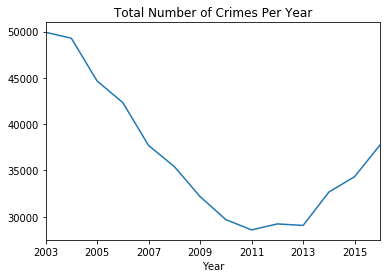

In [11]:
crimes_year.plot()
plt.title("Total Number of Crimes Per Year")
plt.xticks(np.arange(2003,2017, step=2))
plt.xlabel("Year")

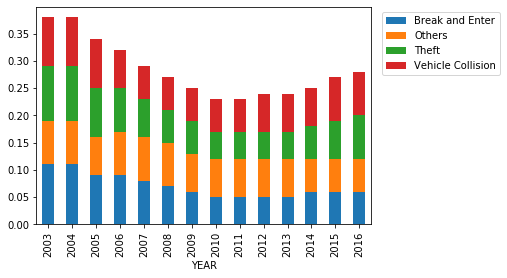

In [12]:
crime_type_by_year = vancouver.groupby(["CATEGORY", "YEAR"]).count()['MONTH']
crime_type_by_year_df = crime_type_by_year.unstack("CATEGORY")
w = vancouver.groupby(['CATEGORY']).count()
div_vec = w['YEAR'] 
crime_type_prop = crime_type_by_year_df.div(div_vec).round(2)
crime_type_prop.stack()

crime_type_prop.plot(kind='bar', stacked=True).legend(loc='upper right', bbox_to_anchor=(1.4,1));

## Crime Distribution Per Day of the Year

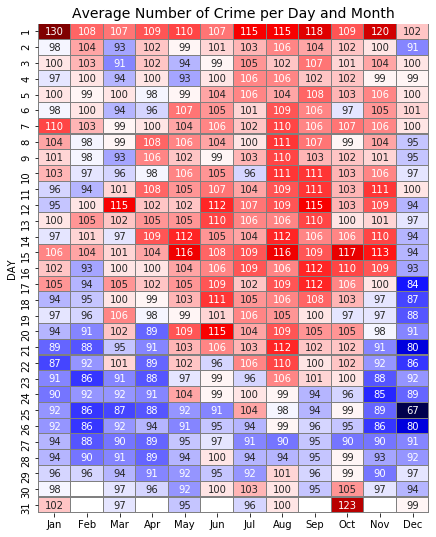

In [13]:
crimes_pivot_table = vancouver[(vancouver['DATE'] != '2011-06-15')].pivot_table(values='YEAR', 
                                                                                index='DAY', columns='MONTH', aggfunc=len)

crimes_pivot_table_year_count = vancouver[(vancouver['DATE'] != '2011-06-15')].pivot_table(
    values='YEAR',index='DAY', columns='MONTH', aggfunc=lambda x: len(x.unique()))


crimes_average = crimes_pivot_table/crimes_pivot_table_year_count
crimes_average.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# Using seaborn heatmap
plt.figure(figsize=(7,9))
plt.title('Average Number of Crime per Day and Month', fontsize=14)
sns.heatmap(crimes_average.round(), cmap='seismic', linecolor='grey',linewidths=0.1, cbar=False, annot=True, fmt=".0f");

It seems like criminals are less active in the later parts of each month -- maybe rent is due at the beginning? Also, Christmas is by far the day with the least arrests, either because no one is committing crimes, or because no one is out there to arrest them. Unsurprisingly, New Year's Day is the day with consistently the most arrests. This makes sense because there are many drunk partiers that get into trouble on New Year's. What's a little more suprising is the spike of crime on Halloween. Maybe people take their pranks too far and commit crimes.

In [14]:
vancouver.drop(['DATE'], axis=1, inplace=True)

In [15]:
days = vancouver.groupby(["DATE"]).count()['TYPE']

daily_counts = vancouver.groupby(['TYPE','YEAR', 'MONTH', 'DAY'])['HOUR'].count().unstack("TYPE")

mischief_days = daily_counts['Mischief']
break_comm_days = daily_counts['Break and Enter Commercial']
break_res_days = daily_counts['Break and Enter Residential/Other']
homicide_days = vancouver[vancouver.TYPE == 'Homicide'].groupby("DATE").count()['TYPE']
person_off_days = vancouver[vancouver.TYPE == 'Offence Against a Person'].groupby("DATE").count()['TYPE']
other_theft_days = daily_counts['Other Theft']
theft_ve_days = daily_counts['Theft from Vehicle']
theft_bi_days = daily_counts['Theft of Bicycle']
theft_car_days = daily_counts['Theft of Vehicle']
car_crash_injury_days = daily_counts['Vehicle Collision or Pedestrian Struck (with Injury)']
car_crash_death_days = daily_counts['Vehicle Collision or Pedestrian Struck (with Fatality)']

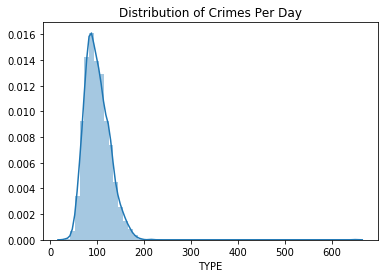

In [16]:
sns.distplot(days, bins=60)
plt.title("Distribution of Crimes Per Day");

This data seems to be approximately Normally distributed, with a mean of about 100 crimes per day. 

However, There was a day with 600+ crimes? Which day was it?

In [17]:
heavy_crime_days = days[days >= 300]
print(heavy_crime_days)

DATE
2011-06-15    649
Name: TYPE, dtype: int64


June 15th, 2011 was the day of the famous Stanley Cup riots, where angry Canucks fans rioted in the streets after allegedly 
throwing the Stanley Cup finals. These riots created outliers in people arrested for Mischief, as well as Breaking and Entering 
into Commercial Areas, causing an overall massive outlier in the city's crimes per day total (more than 400 more crimes than the next-closest day).

# Individual Outlier Analysis

## Mischief
"In Canada, mischief is a criminal offence that refers to the wilful or reckless destruction of another person's property, or the interference with another person's property. Mischief is often the charge that will be laid following an act of vandalism."

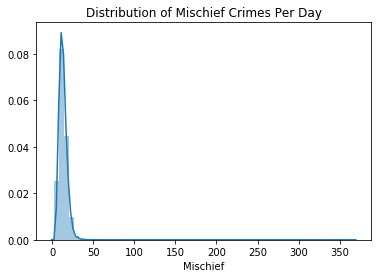

In [18]:
sns.distplot(mischief_days, bins=60)
plt.title("Distribution of Mischief Crimes Per Day");

This data is approximately Normal, with a mean around 20 mischief arrests per day. 

There appears to be one massive outlier aorund 350, but let's check for others to be sure.

In [19]:
mischief_days[(np.abs(stats.zscore(mischief_days) > 5))]

YEAR  MONTH  DAY
2008  3      12     120.0
2011  6      15     367.0
Name: Mischief, dtype: float64

Oh! It looks like there's another day with a massive amount of Mischief crimes.

Let's compare these days to the rest of their weeks to see if they were an explosion of unrest, or just anomalies

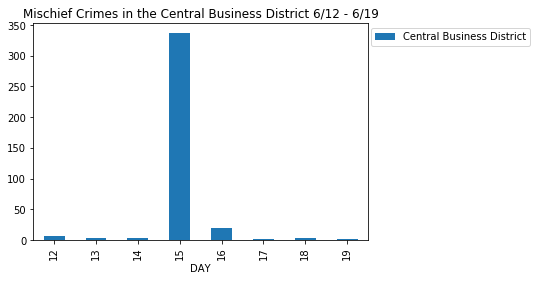

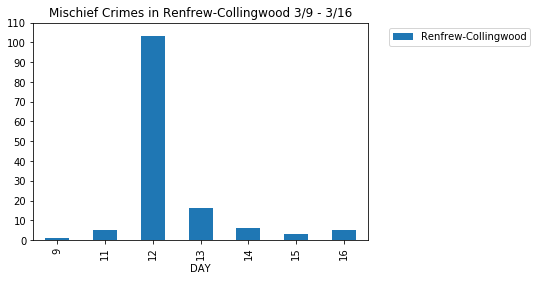

In [20]:
cbd = vancouver[vancouver['YEAR'] == 2011]
cbd1 = cbd[cbd['NEIGHBOURHOOD'] == 'Central Business District']
cbd2 = cbd1[cbd1['MONTH'] == 6]
cbd3 = cbd2[cbd2['DAY'].isin([12,13,14,15,16,17,18,19])]
cbd4 = cbd3[cbd3['TYPE'] == 'Mischief']
mischief_cbd_in_range = cbd4.groupby(['DAY', 'NEIGHBOURHOOD']).count()['TYPE']
mischief_cbd_in_range.unstack().plot(kind='bar')
plt.legend(loc='upper right', bbox_to_anchor=(1.5,1))
plt.title("Mischief Crimes in the Central Business District 6/12 - 6/19");

rc = vancouver[vancouver['YEAR'] == 2008]
rc1 = rc[rc['NEIGHBOURHOOD'] == 'Renfrew-Collingwood']
rc2 = rc1[rc1['MONTH'] == 3]
rc3 = rc2[rc2['DAY'].isin([9,10,11,12,13,14,15,16])]
rc4 = rc3[rc3['TYPE'] == 'Mischief']
mischief_rc_in_range = rc4.groupby(['DAY', 'NEIGHBOURHOOD']).count()['TYPE']
mischief_rc_in_range.unstack().plot(kind='bar') 
plt.legend(loc='upper right', bbox_to_anchor=(1.5,1))
plt.title("Mischief Crimes in Renfrew-Collingwood 3/9 - 3/16");
plt.yticks(np.arange(0,120, step=10));


It looks like the days where there were lots of Mischief crimes generally came out of nowhere, so to speak, but the elevated rates of Mischief tended to stick around for a day or 2 after, reflecting either heightened policing or tension still in the area.

While the spike in Mischief crimes in the Central Business District can be easily explained by the Stanley Cup Riots, I 
couldn't find a single mention of the 100+ mischief arrests in Renfrew-Collingwood on March 12th, 2008. Since there was an elevated number of Mischief crimes the following day, I don't believe that the 100+ outlier was a reporting error by the Vancouver Police.

Renfrew-Collingwood is a lower-income neighborhood, and this activity did occur in 2008 before the market crash, so maybe this event was triggered by a mass layoff, or something like that. This is pure speculation, but it's weird that so many people were arrested and there's nothing mention of it on the internet at all. Maybe Vancouver PD is hiding something!

Next, we'll compare how these outliers affect the daily Mischief arrest rates of their respective neighborhoods, and how the rates look once the outliers are removed.

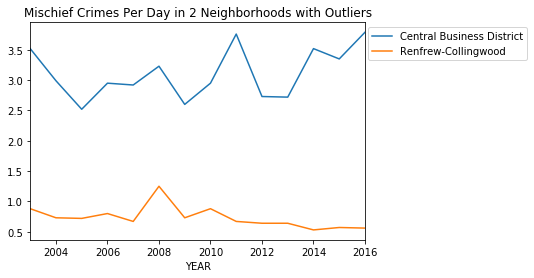

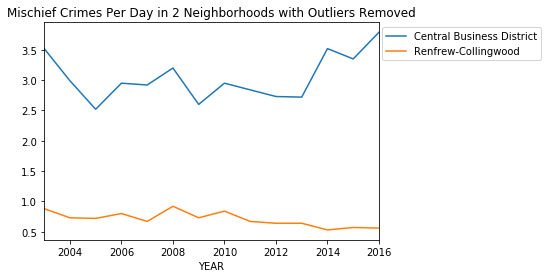

In [21]:
mischief = vancouver[vancouver['TYPE'] == 'Mischief']
mischief_days_by_hood = mischief.groupby(['NEIGHBOURHOOD', 'YEAR']).count()
mischief_per_day = mischief_days_by_hood.unstack('NEIGHBOURHOOD')['TYPE'].div(365.25).round(2)
mischief_per_day[['Central Business District', 'Renfrew-Collingwood']].plot()
plt.title("Mischief Crimes Per Day in 2 Neighborhoods with Outliers")
plt.legend(loc='upper right', bbox_to_anchor=(1.5,1));

mischief_a_day = mischief.groupby(['NEIGHBOURHOOD', 'DAY', 'MONTH', 'YEAR'])['TYPE']
mischief_a_day_df = mischief_a_day.count().unstack('NEIGHBOURHOOD').fillna(0)
mischief_no_outliers =  mischief_a_day_df[(np.abs(stats.zscore(mischief_a_day_df['Central Business District'])) < 5)]
mischief_no_outliers =  mischief_no_outliers[(np.abs(stats.zscore(mischief_no_outliers['Renfrew-Collingwood'])) < 5)]
mischief_no_outliers = mischief_no_outliers.stack().unstack(["YEAR"]).unstack('NEIGHBOURHOOD').sum()

mischief_no_outliers.unstack("NEIGHBOURHOOD")[['Central Business District', 'Renfrew-Collingwood']].div(365.25).round(2).plot()
plt.title("Mischief Crimes Per Day in 2 Neighborhoods with Outliers Removed")
plt.legend(loc='upper right', bbox_to_anchor=(1.5,1));

With the outliers taken out, the graphs more closely resemble the trends given by the Crimes Per Year graph.

## Breaking and Entering (Commercial)



Breaking and Entering into Commerical Buildings was also heavily affected by the Stanley Cup Riots, as many rioting fans
broke into and destroyed businesses downtown. Were there any more significant days where people broke into commercial buildings?

C:\Users\strud\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\strud\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\strud\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\strud\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


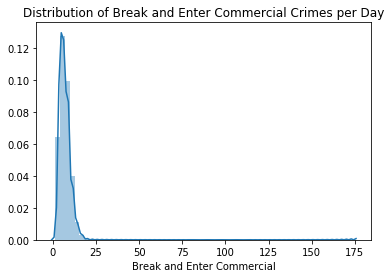

In [22]:
sns.distplot(break_comm_days, bins=60)
plt.title("Distribution of Break and Enter Commercial Crimes per Day");

Breaking and Entering Commercial is distributed normally enough to search for outliers using standard deviation, so I'll do that. 

In [23]:
bcd = vancouver[vancouver.TYPE == 'Break and Enter Commercial'].groupby("DATE").count()['TYPE']
bcd[np.abs(stats.zscore(bcd) > 4)]

DATE
2004-09-16     24
2006-02-03     24
2011-06-15    174
Name: TYPE, dtype: int64

While there were two days with 24 Breaking and Entering (Commercial) crimes, neither are particularly close to the 174 people
arrested for breaking and entering during the 2011 Stanley Cup Riots, so I will be focusing on those. Also, the majority of these Breaking and Entering arrests were made in the Central Business District as a direct result of the riots, so I will be focusing on that neighborhood.

In [24]:
vancouver['2011-06-15'][vancouver['2011-06-15'].TYPE == 'Break and Enter Commercial'].NEIGHBOURHOOD.value_counts()

Central Business District    171
Fairview                       1
Victoria-Fraserview            1
Dunbar-Southlands              1
Name: NEIGHBOURHOOD, dtype: int64

Yeah, 171 people were arrested in the Central Business District for breaking into stores during the riots. Crazy stuff.

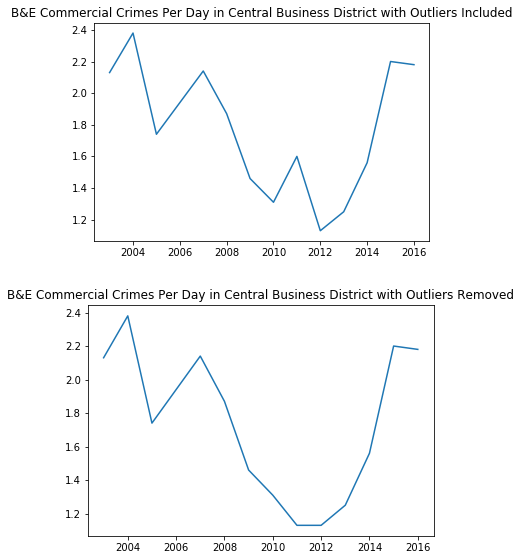

In [25]:
fig = plt.figure()

bec = vancouver[vancouver.TYPE == "Break and Enter Commercial"].groupby(['NEIGHBOURHOOD', 'YEAR', 'MONTH', 'DAY'])['TYPE']
break_comm_df = bec.count().unstack('NEIGHBOURHOOD').fillna(0)
bec_cbd_sum = break_comm_df.stack().unstack("YEAR").unstack("NEIGHBOURHOOD").sum()

ax1=fig.add_subplot(111)
ax1.plot(bec_cbd_sum.unstack("NEIGHBOURHOOD")['Central Business District'].div(365.25).round(2))
plt.title("B&E Commercial Crimes Per Day in Central Business District with Outliers Included")


bec_cbd_no_outliers =  break_comm_df[(np.abs(stats.zscore(break_comm_df['Central Business District'])) < 5)]
bec_cbd_no_outliers_sum = bec_cbd_no_outliers.stack().unstack("YEAR").unstack("NEIGHBOURHOOD").sum()

ax2 = fig.add_axes([0.11, -.9, .8, .8])
ax2.plot(bec_cbd_no_outliers_sum.unstack("NEIGHBOURHOOD")['Central Business District'].div(365.25).round(2))
plt.title("B&E Commercial Crimes Per Day in Central Business District with Outliers Removed");


The exclusion of the Stanley Cup Riots allows us to see that the city's initiative to cut down break-ins from 2007-2012 really 
worked!

## Theft From Vehicle

Next, I'd like to look at how often things were stolen from vehicles.

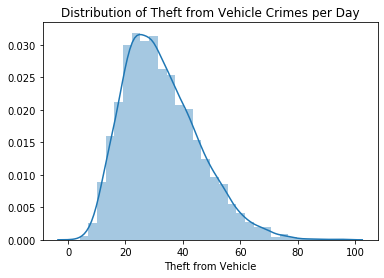

In [26]:
sns.distplot(theft_ve_days, bins=30)
plt.title("Distribution of Theft from Vehicle Crimes per Day");

It looks like there's a day where over 100 people were arrested for stealing from cars. Let's find out when it was!

This data looks almost normally distributed (with a very high number of observations) so I will once again use z-score to find outliers. 

In [27]:
tfv = vancouver[vancouver.TYPE == 'Theft from Vehicle'].groupby("DATE").count()['TYPE']
tfv[np.abs(stats.zscore(tfv) > 4)]

DATE
2003-05-16    95
2003-05-17    86
2004-11-12    92
2004-11-14    87
2005-04-08    95
2006-01-07    86
Name: TYPE, dtype: int64

I guess there weren't any days over 100. It also seems like all of the days with a high number of people stealing from cars occurred before 2010. This reflects the general trend of the crime rate going down before the 2010, possibly due to the Olympics.

Finally, it seems that there was a crime spree in mid-May 2003, as well as one in mid-November 2004, where there were sustained high levels of car thievery.

Also, for once, the spikes in crime were unrelated to the Stanley Cup riots.

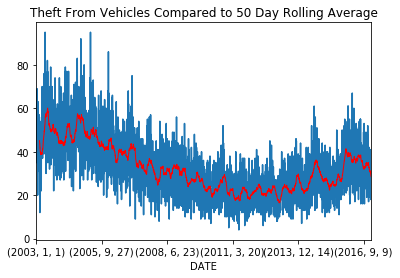

In [28]:
theft_ve_days.plot()
rolling_mean = theft_ve_days.rolling(window=50).mean()
rolling_mean.plot(color='red', linewidth=1)
plt.title("Theft From Vehicles Compared to 50 Day Rolling Average")
plt.xlabel("DATE")
plt.locator_params(axis='x', nbins=10)

The average drops considerably from 2003 to 2011, then rebounds by the middle of the 2010s. This explains why all the outliers I found using z-scores were all from the early-to-mid 2000s.

## Theft of Bikes and Vehicles
These have very similar graphs, and since both are theft of modes of transportation, I figured they would work together well.

C:\Users\strud\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\strud\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\strud\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\strud\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


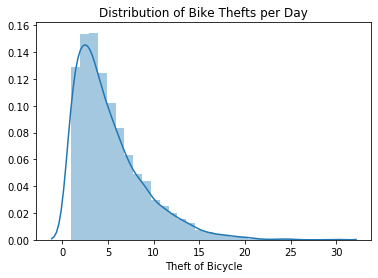

In [29]:
sns.distplot(theft_bi_days, bins=30)
plt.title("Distribution of Bike Thefts per Day");

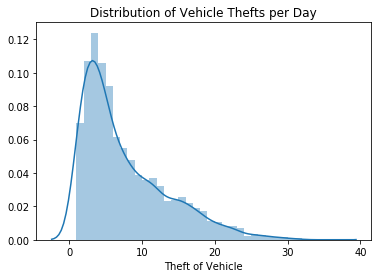

In [30]:
sns.distplot(theft_car_days, bins=35)
plt.title("Distribution of Vehicle Thefts per Day");

Not exactly Normally Distributed, but will use CLT to assume normality and find zscores for outliers.

### Bike Theft

In [31]:
tob = vancouver[vancouver.TYPE == 'Theft of Bicycle'].groupby("DATE").count()['TYPE']
print(tob[np.abs(stats.zscore(tob) > 4)])

DATE
2010-09-10    22
2014-07-15    25
2015-06-27    24
2015-07-01    25
2015-07-05    24
2015-07-08    21
2015-07-15    24
2015-07-21    23
2015-07-22    30
2015-08-03    21
2015-08-18    21
2016-05-07    22
2016-05-18    25
2016-05-21    30
2016-07-22    21
Name: TYPE, dtype: int64


It seems like the Vancouver Police Department placed an emphasis on arresting bike thieves starting in 2015, because almost all the major arrest days are after 2014. Also, none of these heavy arrest days occur during the winter. This makes sense because Canadian winters are cold -- there are less bikes around and less people motivated to steal them.

Let's check to see what days have the least bike thefts:

In [32]:
print(tob[tob == 1].count())
print(tob[tob==0].count())

print(598/tob.count())

598
0
0.12447960033305579


12.4% of days only had one arrest for a stolen bike, but surprisingly there were no days with zero arrests for a stolen bike.

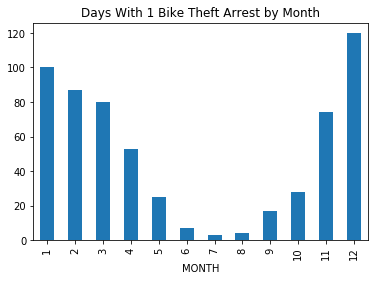

In [33]:
bt = vancouver[vancouver.TYPE == "Theft of Bicycle"]
bty = bt.groupby(["DAY", "MONTH", "YEAR"]).count() [bt.groupby(["DAY", "MONTH", "YEAR"]).count() <= 1 ]['TYPE']
bty.unstack("MONTH").count().plot(kind='bar')
plt.title("Days With 1 Bike Theft Arrest by Month");

Here we can clearly see that people don't steal as many bikes in the winter, either because victims don't use them as much, or because criminals don't want them.

### Vehicle Theft

Let's see what our outlier dates look like.

In [34]:
tov = vancouver[vancouver.TYPE == 'Theft of Vehicle'].groupby("DATE").count()['TYPE']
print(tov[np.abs(stats.zscore(tov) > 4)])

DATE
2003-06-20    32
2004-03-29    36
Name: TYPE, dtype: int64


Much like the "Thefts from Vehicles" section, it seems that the heavy carjacking days happened in the early-to mid 2000s.

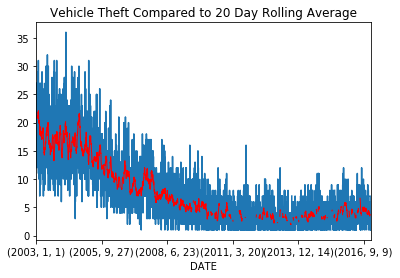

In [35]:
theft_car_days.plot()
rolling_mean = theft_car_days.rolling(window=20).mean()
rolling_mean.plot(color='red', linewidth=1)
plt.title("Vehicle Theft Compared to 20 Day Rolling Average")
plt.xlabel("DATE")
plt.locator_params(axis='x', nbins=10)

Just as I suspected, the rolling average proves that car thievery decreased from the mid-2000s to the present from about 17 cars stolen a day to a much more palatable 5 per day.

Interestingly enough, it seems like the riots are also an outlier for the time period. Let's check.

In [36]:
tcd = theft_car_days[2011]
print(tcd.mean())
tcd[tcd>10]

3.2529761904761907


MONTH  DAY
10     10     16.0
       12     14.0
Name: Theft of Vehicle, dtype: float64

Oh, this isn't what I expected at all. These vehicle thefts weren't during the riots at all! Interestingly, both outliers happened within two days of each other. Unsurprisingly, there aren't any news articles about the subject, but I'm sure the people affected by the carjackings weren't too pleased with their cars stolen in a string of robberies. Let's see if they might be connected. 

In [37]:
vancouver["2011-10-10"][vancouver["2011-10-10"].TYPE == "Theft of Vehicle"].NEIGHBOURHOOD.value_counts()

Hastings-Sunrise            4
Strathcona                  2
Sunset                      2
Kensington-Cedar Cottage    2
Victoria-Fraserview         2
Grandview-Woodland          1
West End                    1
Renfrew-Collingwood         1
West Point Grey             1
Name: NEIGHBOURHOOD, dtype: int64

In [38]:
vancouver["2011-10-12"][vancouver["2011-10-12"].TYPE == "Theft of Vehicle"].NEIGHBOURHOOD.value_counts()

Grandview-Woodland           4
Kensington-Cedar Cottage     3
Hastings-Sunrise             2
Killarney                    1
Renfrew-Collingwood          1
Central Business District    1
Sunset                       1
Victoria-Fraserview          1
Name: NEIGHBOURHOOD, dtype: int64

Many of these thefts occur in Grandview-Woodland, Kensington-Cedar Cottage, and Hastings-Sunrise, which geographically are close together. However, this does not tell us enough to prove that these were anything more than isolated incidents.

## Breaking and Entering Residential

C:\Users\strud\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\strud\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\strud\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\strud\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


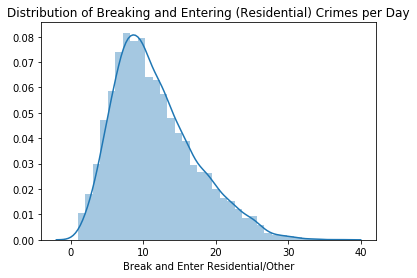

In [39]:
sns.distplot(break_res_days, bins=35)
plt.title("Distribution of Breaking and Entering (Residential) Crimes per Day");

This graph seems mostly clean, with one outlier day where about 40 homes were broken into. Let's see when and where this occurred. Again, I'll be using z-scores to find our outliers.

In [40]:
ber = vancouver[vancouver.TYPE == 'Break and Enter Residential/Other'].groupby("DATE").count()['TYPE']
ber[np.abs(stats.zscore(ber) > 4)]

DATE
2003-04-03    34
2003-04-26    34
2004-03-08    37
Name: TYPE, dtype: int64

It seems like most of these crimes occurred in the Spring months of the early/mid 2000s, where Vancouver had more crime than it does now.

Let's check which neighborhoods the thieves hit most often:

In [41]:
vancouver["2003-04-03"][vancouver["2003-04-03"].TYPE == "Break and Enter Residential/Other"].NEIGHBOURHOOD.value_counts().head()

Oakridge                     6
Sunset                       3
Central Business District    3
Dunbar-Southlands            3
Marpole                      3
Name: NEIGHBOURHOOD, dtype: int64

In [42]:
vancouver["2003-04-26"][vancouver["2003-04-26"].TYPE == "Break and Enter Residential/Other"].NEIGHBOURHOOD.value_counts().head()

Hastings-Sunrise             9
Kitsilano                    5
Sunset                       5
Renfrew-Collingwood          3
Central Business District    2
Name: NEIGHBOURHOOD, dtype: int64

In [43]:
vancouver["2004-03-08"][vancouver["2004-03-08"].TYPE == "Break and Enter Residential/Other"].NEIGHBOURHOOD.value_counts().head()

Mount Pleasant        4
Grandview-Woodland    4
Sunset                4
Fairview              4
Riley Park            3
Name: NEIGHBOURHOOD, dtype: int64

Interestingly enough, there was no specific neighborhood targeted for mulitple major attacks.

## Other Theft

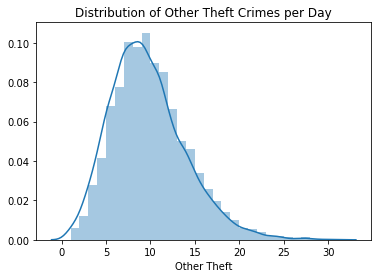

In [44]:
sns.distplot(other_theft_days, bins=30)
plt.title("Distribution of Other Theft Crimes per Day");

Another nice, Normal-ish graph. Let's see when that outlier near 30 occurred.

In [45]:
ot = vancouver[vancouver.TYPE == 'Other Theft'].groupby("DATE").count()['TYPE']
ot[np.abs(stats.zscore(ot) > 4)]

DATE
2015-01-16    27
2016-02-13    29
2016-02-23    27
2016-03-08    28
2016-03-12    27
2016-03-17    27
2016-05-17    31
2016-06-11    27
2016-09-09    28
2016-09-11    30
2016-10-16    27
2016-10-17    28
Name: TYPE, dtype: int64

These results are very similar to the bike theft ones. It seems like either the Vancouver PD are more interested in arresting robbers, or there are more criminals interested in robbing people. Either way, the number of "Other Thefts" has increased in the post-2010 era.

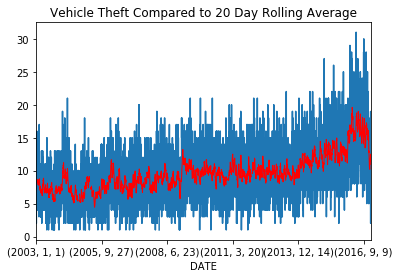

In [46]:
other_theft_days.plot()
rolling_mean = other_theft_days.rolling(window=20).mean()
rolling_mean.plot(color='red', linewidth=1)
plt.title("Vehicle Theft Compared to 20 Day Rolling Average")
plt.xlabel("DATE")
plt.locator_params(axis='x', nbins=10)

In fact, it looks like the average for theft spiked in the time period where we found our outliers.

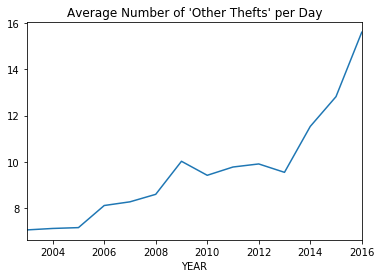

In [47]:
other_theft_days.groupby("YEAR").mean().plot()
plt.title("Average Number of 'Other Thefts' per Day");

This graph of averages seems to back that up. Arrests for theft have doubled in the past 15 years.

## Offence Against A Person

"The term “crimes against the person” refers to a broad array of criminal offenses which usually involve bodily harm, the threat of bodily harm, or other actions committed against the will of an individual. ... Additionally, offenses such as harassment, kidnapping, and stalking also are considered crimes against the person."

Another nicely distributed crime. Thanks, criminals! There are several days where it seems like people committed about quadruple the average number of Personal Offences, so let's see when they were and if we can make any conclusions off of them.

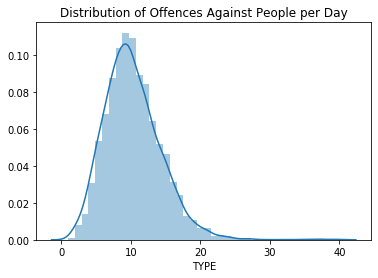

In [48]:
sns.distplot(person_off_days, bins=40)
plt.title("Distribution of Offences Against People per Day");

In [49]:
cap = vancouver[vancouver.TYPE == 'Offence Against a Person'].groupby("DATE").count()['TYPE']
cap[np.abs(stats.zscore(cap) > 5)]

DATE
2004-01-01    40
2005-01-01    36
2006-01-01    39
2007-01-01    32
2008-01-01    39
2010-01-01    37
2011-01-01    37
2011-06-15    35
2012-01-01    31
2013-01-01    37
2014-01-01    34
Name: TYPE, dtype: int64

Well, it seems like Vancouverites party a little to hardy on New Year's Day. It's impressive at this point when a crime anomoly has more criminal activity than the Stanley Cup Riots, yet here we are.

In [50]:
oaap1 = vancouver[vancouver['TYPE'] == 'Offence Against a Person']
oaap = oaap1[oaap1['DAY'] == 1]
oaap = oaap[oaap['MONTH'] == 1]
oaap_on_new_years = oaap.count()['TYPE']

print(1/365)

oaap_ny_prop = oaap_on_new_years/vancouver[vancouver['TYPE'] == 'Offence Against a Person'].count()['TYPE']
oaap_ny_prop

0.0027397260273972603


0.008831870871956906

Nearly 1% of all of Vancouver's Offences Against People occur on New Year's Day! It's essentially 4 times more likely that you get arrested for Offence Against a Person on New Year's than on any other day of the year.

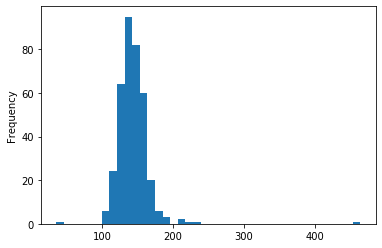

In [51]:
oaap2 = oaap1.groupby(["DAY", "MONTH"]).count()['TYPE']
oaap2.plot(kind='hist', bins=40)

What's the tiny outlier?

In [52]:
oaap2[oaap2 < 100]

DAY  MONTH
29   2        35
Name: TYPE, dtype: int64

That's anti-climactic... The leap day in February of course makes sense as a low outlier. I kind of thought it was going to be Christmas.

## Car Crashes With Injury

C:\Users\strud\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\strud\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\strud\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\strud\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


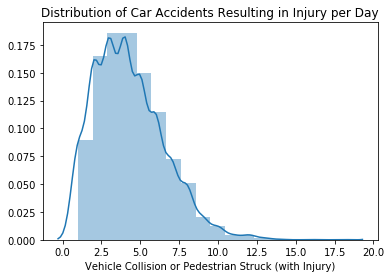

In [53]:
sns.distplot(car_crash_injury_days, bins=18)
plt.title("Distribution of Car Accidents Resulting in Injury per Day");

Not exactly the prettiest graph, but there are some outliers that we can explore. I'm guessing that these will be on holidays where many drunk drivers are on the road.

In [54]:
ccwi = vancouver[vancouver.TYPE == 'Vehicle Collision or Pedestrian Struck (with Injury)'].groupby("DATE").count()['TYPE']
ccwi[np.abs(stats.zscore(ccwi) > 5)]

DATE
2003-04-07    18
2004-10-29    16
Name: TYPE, dtype: int64

Nothing of note happened on either of these days, so I guess I was wrong.

Let's see if they were concentrated in a certain neighborhood.

In [55]:
vancouver["2003-04-07"][vancouver["2003-04-07"].TYPE == "Vehicle Collision or Pedestrian Struck (with Injury)"].NEIGHBOURHOOD.value_counts().head()

Fairview               5
Riley Park             2
Mount Pleasant         2
Victoria-Fraserview    2
Strathcona             1
Name: NEIGHBOURHOOD, dtype: int64

In [56]:
vancouver["2004-10-29"][vancouver["2004-10-29"].TYPE == "Vehicle Collision or Pedestrian Struck (with Injury)"].NEIGHBOURHOOD.value_counts().head()

Renfrew-Collingwood          4
Strathcona                   2
Central Business District    1
Hastings-Sunrise             1
Marpole                      1
Name: NEIGHBOURHOOD, dtype: int64

Nothing seems particularly special about the neighborhoods either. The weather forecasts for both of these days say that it had been raining, but it rains a lot in Vancouver so I'm not convinced it's anything more than a freak accident.

## General Notes about Homicide and Car Crashes With Fatalities

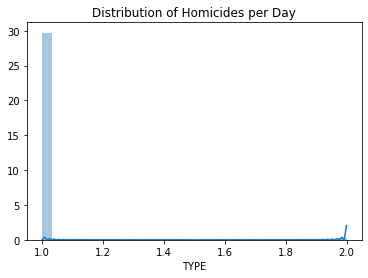

In [57]:
sns.distplot(homicide_days, bins=30)
plt.title("Distribution of Homicides per Day");

This graph, much like the incomplete homicide data, tells us almost nothing. We know that, on the days the homicide was actually reported and extractable, the largest number of homicides committed in a day was a whopping 2. Every other entry had 1 homicide. So, this graph tells us nothing, next.

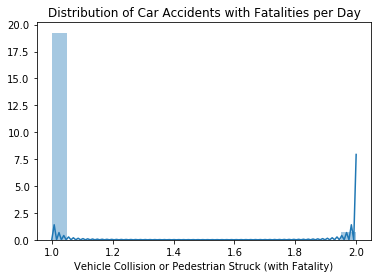

In [58]:
sns.distplot(car_crash_death_days, bins=20)
plt.title("Distribution of Car Accidents with Fatalities per Day");

This is almost the exact same graph as above, and is about as useful, sadly.